# Notebook 2: Cleaning and EDA

Welcome to Notebook 2. In this notebook we clean the data and explore it in step 1. In step 2 we do extensive EDA including word count analysis, analysis of most common words, sentiment analysis and examination of interesting text features (eg. URLs).

# 1. Cleaning

### Imports and reading back in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from wordcloud import WordCloud

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 350

In [2]:
pwd

'/Users/ae-j/Documents/GA/PL/Submissions/Projects/project_3-master/code'

In [3]:
cd ..

/Users/ae-j/Documents/GA/PL/Submissions/Projects/project_3-master


In [4]:
## Reading back in to handle NaN's
df = pd.read_csv('./data/big_df.csv', na_values = 'NaN')

#### Dealing with nulls

In [5]:
df.isnull().sum()

author_fullname      3
selftext           244
title                0
subreddit            0
score                0
id                   0
over_18              0
dtype: int64

Quite a few missing author names and selftext but all titles are there so this still be interesting.

In [6]:
df.fillna('', inplace = True)

In [7]:
##Dropping duplicates
df.drop_duplicates('id', inplace=True)

In [8]:
df.dtypes

author_fullname    object
selftext           object
title              object
subreddit          object
score               int64
id                 object
over_18              bool
dtype: object

#### Creating a 'combined' Column 

Combined column is a selftext + title column because there is a lot of dropped text/deleted text in the anxiety csv as well as about 10% missing text values overall.

In [9]:
df['combined'] = df['selftext'] + ' ' + df['title']

In [10]:
df.head(1)

,author_fullname,selftext,title,subreddit,score,id,over_18,combined
0,t2_1k53nux0,"If a person triggers your ocd and causes you to have intrusive thoughts, in particular about them, that creates a great deal of mental contamination as a result. And if this person is someone in your family that you never communicate but live with, and is largely triggering due to a lot of unresolved conflicts, and complex trauma that has never...",Person triggers me,OCD,1,abfhc9,False,"If a person triggers your ocd and causes you to have intrusive thoughts, in particular about them, that creates a great deal of mental contamination as a result. And if this person is someone in your family that you never communicate but live with, and is largely triggering due to a lot of unresolved conflicts, and complex trauma that has never..."


### Checking out value counts for over_18

Unclear if this is accurate or not. If so it's pretty wild though I'm guessing most users don't have to register their age unless they are explicitly asked to in order to acccess over_18 subreddits. 

In [11]:
print(df.loc[df['subreddit'] == 'OCD', 'over_18'].value_counts())

False    1194
True        6
Name: over_18, dtype: int64


In [12]:
print(df.loc[df['subreddit'] == 'Anxiety', 'over_18'].value_counts())

False    1200
Name: over_18, dtype: int64


# 2. EDA

## 2.1 Anxiety v. OCD word count visualizations

In [13]:
# Selftext wordcount

#### Creating Total Word Count Distributions

In [14]:
df['selftext_word_count'] = df['selftext'].str.count(' ') + 1

df['title_word_count'] = df['title'].str.count(' ') + 1

df['combined_word_count'] = df['combined'].str.count(' ') + 1

In [15]:
st_word_ocd = df.loc[(df['subreddit'] == 'OCD') & (df['selftext_word_count'] < 500), 'selftext_word_count']
st_word_anx = df.loc[(df['subreddit'] == 'Anxiety') & (df['selftext_word_count'] < 500), 'selftext_word_count']

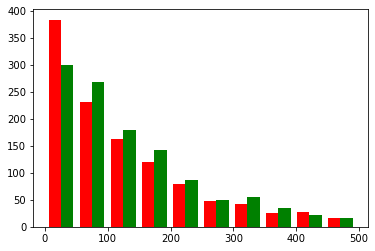

In [16]:
plt.hist([st_word_ocd, st_word_anx], color = ['r', 'g']);

In [17]:
tit_word_ocd = df.loc[(df['subreddit'] == 'OCD') & (df['title_word_count'] < 30), 'title_word_count']
tit_word_anx = df.loc[(df['subreddit'] == 'Anxiety') & (df['title_word_count'] < 30), 'title_word_count']

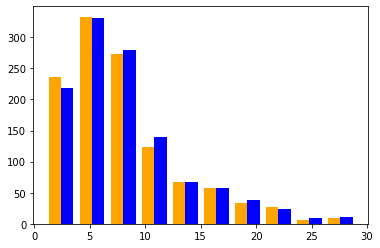

In [18]:
plt.hist([tit_word_ocd, tit_word_anx], color = ['orange', 'blue']);

### Summary Statistics for Words

We see slightly shorter max posts and titles on the anxiety subreddit than the OCD subreddit but a pretty similar mean and std so roughly the same overall.

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
score,2400.0,12.350417,82.580481,0.0,1.0,1.0,3.0,2815.0
selftext_word_count,2400.0,154.022083,179.886551,1.0,42.0,101.0,200.0,2346.0
title_word_count,2400.0,8.730417,7.360105,1.0,4.0,7.0,11.0,59.0
combined_word_count,2400.0,162.752500,179.826660,2.0,51.0,109.0,210.0,2355.0


In [20]:
df.loc[df['subreddit'] == 'OCD'].describe().T

,count,mean,std,min,25%,50%,75%,max
score,1200.0,13.026667,61.147773,0.0,1.00,1.0,3.0,642.0
selftext_word_count,1200.0,155.713333,198.913352,1.0,33.75,96.0,199.0,2346.0
title_word_count,1200.0,8.711667,7.536745,1.0,4.00,7.0,11.0,57.0
combined_word_count,1200.0,164.425000,198.706445,2.0,42.00,103.0,207.0,2355.0


In [21]:
df.loc[df['subreddit'] == 'Anxiety'].describe().T

,count,mean,std,min,25%,50%,75%,max
score,1200.0,11.674167,99.522830,0.0,1.00,1.0,3.00,2815.0
selftext_word_count,1200.0,152.330833,158.660278,1.0,50.75,106.0,202.25,1660.0
title_word_count,1200.0,8.749167,7.182217,1.0,4.00,7.0,11.00,59.0
combined_word_count,1200.0,161.080000,158.784053,2.0,58.00,113.5,212.00,1663.0


## 2.2 CountVectorizer Work

Here we set stopwords, create visualizations of most common words and prepare data for wordcloud visualizations in the next step.

### Setting Stopwords

Here I did manual assignment of stopwords as, given the colloqiual nature of a lot of the posts, many of the most frequent words were words that likely have little predictive value but were not classified as english stopwords (eg. 'just' and 'like' were top 5 words in both subreddits!) In Notebook 3 these will be fed into the grid search as parameters.

In [22]:
#Base code from lesson 5.04. Modified to fit my purposes
my_stopwords2 = list(CountVectorizer(stop_words = 'english').get_stop_words()) + ['just', 'like', 've', 'don','really', 'things', 'deleted', 'feel', 'want', 'years', 'help', 'going', 'make', 'day', 'having', 'bad', 'got', 'way', "I'm", "I've", "I'll", 'n', 't', 's', 'm', 'g', 'll']

### Creating CountVector and Visualization for OCD

In [23]:
cvec = CountVectorizer(stop_words = my_stopwords2)

x = df.loc[df['subreddit'] == 'OCD', 'combined']

cvec.fit(x)
z = cvec.transform(x)
z_df = pd.DataFrame(z.todense(), columns = cvec.get_feature_names())

In [24]:
pd.DataFrame(z_df.sum().sort_values(ascending = False).head(20))

,0
ocd,1717
thoughts,850
know,712
think,579
time,551
people,438
thought,429
anxiety,398
life,367
intrusive,365


#### Most common words - OCD 

<AxesSubplot:>

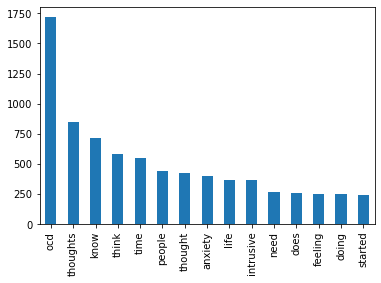

In [25]:
z_df.sum().sort_values(ascending = False).head(15).plot(kind='bar')

### Creating CountVector and Visualization for Anxiety

In [26]:
cvec2 = CountVectorizer(stop_words = my_stopwords2)
y = df.loc[df['subreddit'] == 'Anxiety', 'combined']

cvec2.fit(y)
z2 = cvec2.transform(y)
z_df2 = pd.DataFrame(z2.todense(), columns = cvec2.get_feature_names())

pd.DataFrame(z_df2.sum().sort_values(ascending = False).head(20))

,0
anxiety,1700
know,747
time,633
people,478
work,435
think,431
life,374
anxious,371
panic,362
feeling,359


#### Most common words - Anxiety

<AxesSubplot:>

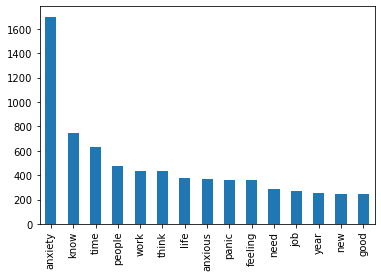

In [27]:
z_df2.sum().sort_values(ascending = False).head(15).plot(kind='bar')

## 2.3 Visualizing with a wordcloud

The data really doesn't jump out with the CountVectorizer work above. The wordcount visualization, by contrast, really drives home the cognitive nature of OCD and the more feeling/emotion driven nature of Anxiety. 

In [28]:
#Base code came from the following link. Modified to fit my needs: https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

def wordcloud_gen(subr, color, title = None):
    wordcloud = WordCloud(
        
        stopwords=my_stopwords2,
        max_words=100,
        max_font_size=40, 
        background_color='lightyellow',
        colormap=color,
        scale=3,
        contour_width=2,
        contour_color='rdsf',
        random_state=42, 
    ).generate(str(subr))

    plt.figure(figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

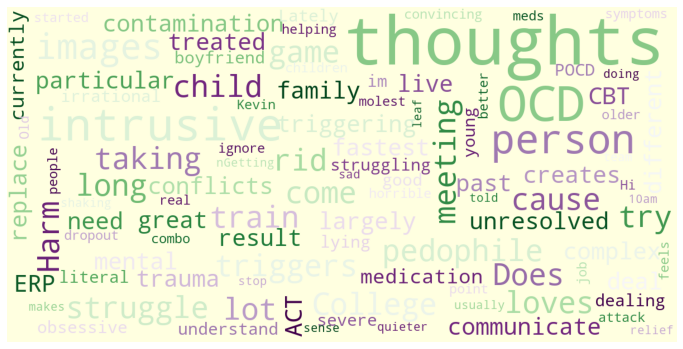

In [29]:
fig1 = wordcloud_gen(df.loc[df['subreddit'] == 'OCD', 'combined'], "PRGn")

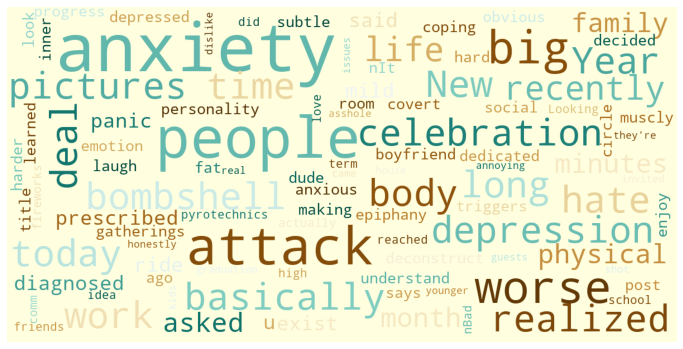

In [30]:
fig2 = wordcloud_gen(df.loc[df['subreddit'] == 'Anxiety', 'combined'], 'BrBG')

### Exporting Data for use in Notebook 3

In [31]:
## df.to_csv('./data/after_eda.csv', index = False)

# 2.4 Sentiment Analysis

Sentiment Analysis done in order to understand the overall sentiment in the posts and compare that with subreddit specific sentiment. This allows us to get a sense of average compound sentiment (mean) and assess composition of the posts as well as identify sources of potential bias toward negative words in the data. This is relevant to the purpose of this analysis as we will be asking people to describe what it feels like in their mind when they are off-balance which is almost definitely going to carry a negative compound sentiment. So for purposes of prediction, if the sentiment in these posts was overwhelmingly positive, we might have a bad fit between the data we're training/testing on and the actual (non-medical) diagnostic tool.

In [32]:
sia = SentimentIntensityAnalyzer()

In [33]:
## Code from 5.03 modified to fit my needs.
scores = []

for each in df['combined']:
    current_scores = sia.polarity_scores(each)
    scores.append(current_scores)

### Full Dataframe SIA

In [34]:
scores_df = pd.DataFrame(scores)
scores_df['compound'].mean()

-0.24368691666666686

In [35]:
df = pd.concat([df, scores_df], axis=1)

df.sort_values(by='compound', ascending=False).head(15)

df.head(1)

,author_fullname,selftext,title,subreddit,score,id,over_18,combined,selftext_word_count,title_word_count,combined_word_count,neg,neu,pos,compound
0,t2_1k53nux0,"If a person triggers your ocd and causes you to have intrusive thoughts, in particular about them, that creates a great deal of mental contamination as a result. And if this person is someone in your family that you never communicate but live with, and is largely triggering due to a lot of unresolved conflicts, and complex trauma that has never...",Person triggers me,OCD,1,abfhc9,False,"If a person triggers your ocd and causes you to have intrusive thoughts, in particular about them, that creates a great deal of mental contamination as a result. And if this person is someone in your family that you never communicate but live with, and is largely triggering due to a lot of unresolved conflicts, and complex trauma that has never...",637,3,640,0.17,0.696,0.134,-0.9855


<BarContainer object of 2400 artists>

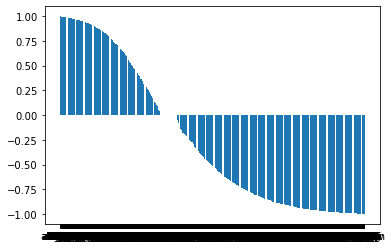

In [36]:
plt.bar(df['id'], df['compound'].sort_values(ascending=False))

### OCD only SIA

In [37]:
df_ocd = df.loc[df['subreddit'] == 'OCD'].copy()

df_ocd['compound'].mean()

-0.18345866666666671

In [38]:
df_ocd['compound'].median()

-0.3418

<BarContainer object of 1200 artists>

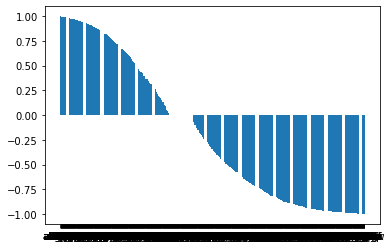

In [39]:
plt.bar(df_ocd['id'], df_ocd['compound'].sort_values(ascending=False))

### Anxiety only SIA

In [40]:
df_anx = df.loc[df['subreddit'] == 'Anxiety'].copy()

In [41]:
df_anx['compound'].mean()

-0.3039151666666672

In [42]:
df_anx['compound'].median()

-0.65345

<BarContainer object of 1200 artists>

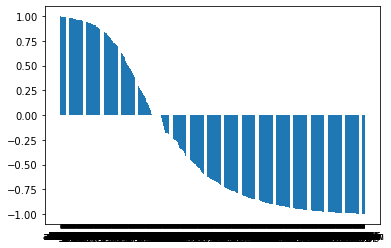

In [43]:
plt.bar(df_anx['id'], df_anx['compound'].sort_values(ascending=False))

### Exporting

In [44]:
#df_anx.to_csv('./data/df_anx.csv', index = False)

In [45]:
#df_ocd.to_csv('./data/df_ocd.csv', index = False)

# 2.5 Searching for URLs

This was sort of a shot in the dark to see what people are talking about in the dataset and if there are some URLs that might be telling or helpful. I thought it would be cool to pull resources from reddit posts - sort of crowdsourcing resources. However, there are only 32 total hits with this code and having read them they are largely pointers to support groups in reddit or facebook groups. 

In [46]:
contains_url = df[df['combined'].str.contains('www')]

In [47]:
contains_url.shape

(32, 15)